In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)

import catboost as ctb
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import f1_score, classification_report


from sklearn.model_selection import StratifiedKFold, cross_val_score
import eli5
from eli5.sklearn import PermutationImportance

import scikitplot as skplt

import matplotlib.pyplot as plt

In [2]:
df_train = pd.read_hdf("../input/train_taiwan.h5")
df_test = pd.read_hdf("../input/test_taiwan.h5")

df_all = pd.concat([df_train, df_test]).reset_index(drop=True)
df_all.columns = [x.replace(" ", "_").lower() for x in df_all.columns]

df_train.shape, df_test.shape, df_all.shape

((3409, 97), (3410, 96), (6819, 97))

In [3]:
# MY CODE PROGENO
initial_num_feats = df_all.select_dtypes("number").columns
initial_feats = [x for x in initial_num_feats if x not in ['target']]

In [4]:
def make_experiment(model, feats=None, threshold=0.5, n_splits=3, black_list=["target"], show_feats=False, show_cr=False, show_cm=False, show_pr=False, show_lc=False):
    
    if feats is None:
        num_feats = df_all.select_dtypes("number").columns
        feats = [x for x in num_feats if x not in black_list]
    
    if show_feats:
        print(feats)
        
    df_train = df_all[ df_all["target"].notnull() ]
    X_train = df_train[feats].values
    y_train = df_train["target"].values

    scores = []
    cv=StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
    for train_idx, test_idx in cv.split(X_train, y_train):    

        model.fit(X_train[train_idx], y_train[train_idx])

        y_probas = model.predict_proba(X_train[test_idx])
        y_pred = (y_probas[:,1] > threshold).astype(np.int)
        #y_pred = model.predict(X_train[test_idx])

        if show_cr:
            print(classification_report(y_train[test_idx], y_pred))
        
        if show_cm:
            skplt.metrics.plot_confusion_matrix(y_train[test_idx], y_pred)#normalize=True
            
        if show_pr:
            skplt.metrics.plot_precision_recall(y_train[test_idx], y_probas)

        score = f1_score(y_train[test_idx], y_pred)
        scores.append(score)
    
    print("Score: ", np.mean(scores), np.std(scores))
    
    skplt.estimators.plot_learning_curve(model, X_train, y_train, cv=cv, scoring="f1", random_state=0)
    
    return eli5.show_weights(model, feature_names=feats, top=50)
    
    
def my_hist(df_all, feat_name, left_perc=1, right_perc=99):
    min_value = np.percentile( df_all[feat_name], 1)
    max_value = np.percentile( df_all[feat_name], 99)

    (
        df_all[ 
            (df_all[feat_name] > min_value) &
            (df_all[feat_name] < max_value)
        ][feat_name]
    ).hist(bins=100)
    plt.title("{}\n, left_perc={}, right_perc={}".format(feat_name, left_perc, right_perc))
    plt.show()
    
    
def save_result(filename, model, threshold=0.1):

    df_train = df_all[ df_all["target"].notnull() ]
    df_test = df_all[ df_all["target"].isnull() ].copy()

    num_feats = df_all.select_dtypes("number").columns
    feats = [x for x in num_feats if x not in ["target"]]

    
    model.fit(df_train[feats].values, df_train["target"].values)

    df_test["target"] = (model.predict_proba(df_test[feats].values)[:,1] > 0.1).astype(np.int)
    output_file = "../output/{}".format(filename)
    df_test[ ["id", "target"] ].to_csv(output_file, index=False)
    print("Saved: ", output_file)

Score:  0.4326876826876827 0.02803963590288893


Weight,Feature
0.0603,continuous_profit_rate_(after_tax)
0.0495,persistent_eps_in_the_last_four_seasons
0.0493,working_capital/equity
0.0486,roa(a)_after_tax_and_before_interest%
0.0420,"roa(b)_after_tax_and_before_interest,_before_depreciation"
0.0401,net_income_to_total_assets
0.0312,tax_rate_(a)
0.0244,total_debt/total_net_worth
0.0242,roa(c)_before_tax_and_interest_before_depreciation
0.0242,book_value_per_share_(b)


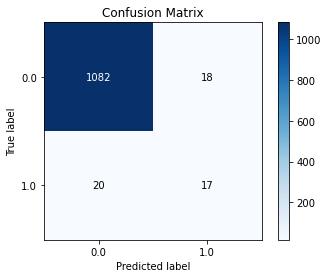

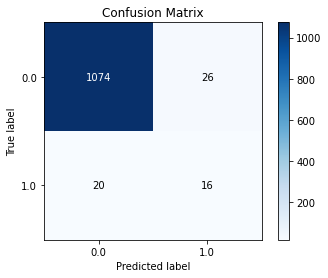

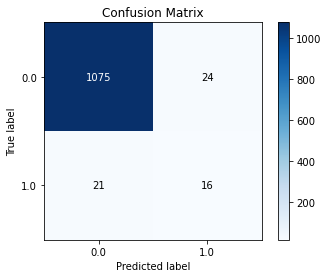

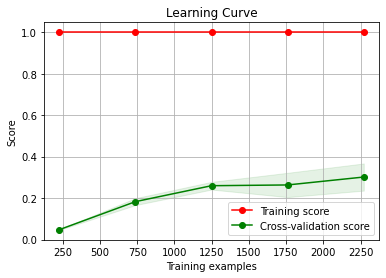

In [5]:
model = xgb.XGBClassifier(max_depth=5, n_estimators=100, random_state=0)
make_experiment(model, threshold=0.1, show_cm=True)

Score:  0.43061538689286616 0.033742663692361445


Weight,Feature
0.0540,cash_/_current_liability
0.0480,interest-bearing_debt_interest_rate
0.0424,roa(c)_before_tax_and_interest_before_depreciation
0.0335,total_income_/_total_expense
0.0334,continuous_profit_rate_(after_tax)
0.0321,retained_earnings/total_assets
0.0316,equity_to_long-term_liability
0.0292,accounts_receivable_turnover
0.0249,net_income_to_total_assets
0.0237,equipment_rate_per_person


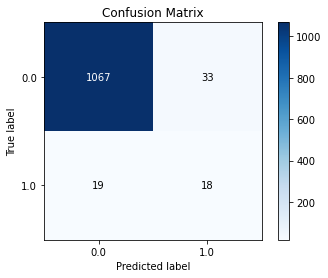

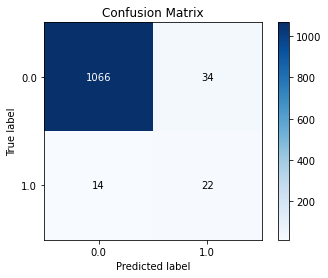

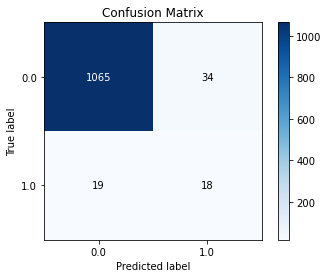

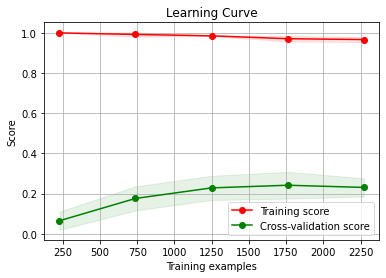

In [6]:
model = ctb.CatBoostClassifier(max_depth=5, n_estimators=100, verbose=0)
make_experiment(model, threshold=0.1, show_cm=True)

Score:  0.464243955932228 0.03206665746593907


Weight,Feature
0.1248,continuous_profit_rate_(after_tax)
0.0881,book_value_per_share_(b)
0.0719,interest-bearing_debt_interest_rate
0.0577,borrowing_dependency
0.0439,net_worth_growth_rate
0.0337,cash_/_current_liability
0.0326,net_income_to_total_assets
0.0325,retained_earnings/total_assets
0.0245,average_collection_days
0.0215,total_assets_growth_rate_


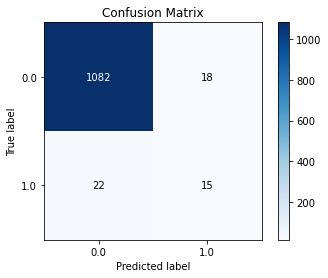

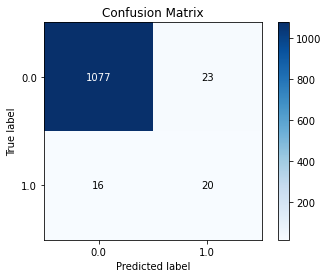

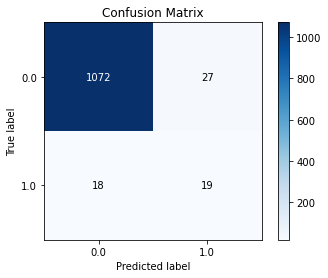

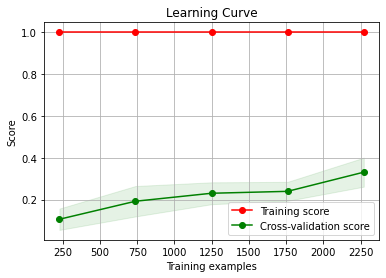

In [7]:
model = lgb.LGBMClassifier(max_depth=5, n_estimators=100)
make_experiment(model, threshold=0.1, show_cm=True)

In [8]:
model = xgb.XGBClassifier(max_depth=5, n_estimators=100, random_state=0)
save_result("xgb_threshold_0.1_a.csv", model)

model = ctb.CatBoostClassifier(max_depth=5, n_estimators=100, verbose=0)
save_result("ctb_threshold_0.1_a.csv", model)

model = lgb.LGBMClassifier(max_depth=5, n_estimators=100)
save_result("lgb_threshold_0.1_a.csv", model)

Saved:  ../output/xgb_threshold_0.1_a.csv
Saved:  ../output/ctb_threshold_0.1_a.csv
Saved:  ../output/lgb_threshold_0.1_a.csv


In [9]:
xgb_output = pd.read_csv("../output/xgb_threshold_0.1_a.csv")
lgb_output = pd.read_csv("../output/lgb_threshold_0.1_a.csv")
ctb_output = pd.read_csv("../output/ctb_threshold_0.1_a.csv")

(0.33*xgb_output["target"] + 0.34*lgb_output["target"] + 0.33*ctb_output["target"]).value_counts()

0.00    3205
1.00      81
0.33      56
0.67      31
0.66      21
0.34      16
Name: target, dtype: int64

In [10]:
output = pd.DataFrame()
output["id"] = xgb_output["id"]
output["target"] = ((0.33*xgb_output["target"] + 0.34*lgb_output["target"] + 0.33*ctb_output["target"]) > 0.2).astype(np.int)

output.to_csv("../output/0.33xgb_0.34lgb_0.33ctb_a.csv", index=False)

In [11]:
## MY CODE PROGENO --- START 

In [12]:
# Outliers 1
multipliers = [1, 2, 3, 4, 5]

for feat in initial_feats:
    for m in multipliers:
        low_boundary, upp_boundary = np.percentile(df_all[feat], [m, 100-m])
       # w ostatecznym zgloszeniu 3 linie poniżej były zakomentowane        
       # df_all["{}_[out1_L_{}]".format(feat,m)] = df_all[feat].map(lambda x: 1 if (x < low_boundary) else 0)
       # df_all["{}_[out1_U_{}]".format(feat,m)] = df_all[feat].map(lambda x: 1 if (x > upp_boundary) else 0)
       # df_all["{}_[out1_{}]".format(feat,m)] = df_all[feat].map(lambda x: 1 if (x < low_boundary) | (x > upp_boundary) else 0)
    
print(df_all.shape)

(6819, 97)


In [13]:
# Outliers 2
multipliers_iqr = [1.5, 3, 4, 5]

for feat in initial_feats:
    q1, q3 = np.percentile(df_all[feat], [25,75])
    iqr = q3 - q1
    for m in multipliers_iqr:
        low_boundary = q1 - (m * iqr)
        upp_boundary = q3 + (m * iqr)
        
        df_all["{}_[out2_L_{}]".format(feat,m)] = df_all[feat].map(lambda x: 1 if (x < low_boundary) else 0)
        df_all["{}_[out2_U_{}]".format(feat,m)] = df_all[feat].map(lambda x: 1 if (x > upp_boundary) else 0)
        df_all["{}_[out2_{}]".format(feat,m)] = df_all[feat].map(lambda x: 1 if (x < low_boundary) | (x > upp_boundary) else 0)
    
print(df_all.shape)

(6819, 1249)


In [14]:
# Dyskretyzacja - dzielenie wartości na przedziały 
print(df_all.shape)        
percentiles = [1, 2, 5, 10, 25, 50, 75, 90, 95, 98, 99]

for feat in initial_feats:
    values = [np.percentile(df_all[feat], percentiles[0])]
    for prc in percentiles[1:]:
        value = np.percentile(df_all[feat], prc)
        if (value > values[-1]):
            values.append(value)
        df_all["{}_[feat_range]".format(feat)] = np.digitize(df_all[feat], bins=values)

print(df_all.shape)                                                                

(6819, 1249)
(6819, 1345)


In [15]:
df_all.groupby('target').mean()

,roa(c)_before_tax_and_interest_before_depreciation,roa(a)_after_tax_and_before_interest%,"roa(b)_after_tax_and_before_interest,_before_depreciation",operating_gross_profit_margin,already_realized_gross_profit_margin_of_sales,operating_profit_rate,net_profit_margin_before_tax,net_profit_margin_after_tax,non-industry_revenue_and_expenditure/revenue,continuous_profit_rate_(after_tax),...,total_assets_to_gnp_price_[feat_range],no-credit_interval_[feat_range],gross_profit_to_sales_[feat_range],net_income_to_stockholder's_equity_[feat_range],liability_to_equity_[feat_range],degree_of_financial_leverage_(dfl)_[feat_range],interest_coverage_ratio(_interest_expense_to_ebit_)_[feat_range],one_if_net_income_was_negative_for_the_last_two_year_zero_otherwise_[feat_range],equity_to_liability_[feat_range],id_[feat_range]
target,,,,,,,,,,,,,,,,,,,,,
0.0,0.507438,0.561123,0.556012,0.607939,0.607926,0.998839,0.797229,0.809084,0.303517,0.781429,...,5.474083,5.505305,5.520461,5.566535,5.456199,5.562595,5.584723,1.0,5.548045,5.489239
1.0,0.418954,0.454040,0.462678,0.597615,0.597702,0.998671,0.796743,0.808700,0.303019,0.780974,...,5.800000,4.636364,3.790909,3.127273,7.481818,4.190909,4.390909,1.0,3.145455,5.790909


In [16]:
#usunięcie cech gdzie są takie same wartosci
print(df_all.shape)

for feat in df_all.columns:
    if(df_all[feat].nunique() == 1):
        df_all = df_all.drop(feat, axis=1)
        
print(df_all.shape)

(6819, 1345)
(6819, 1123)


Score:  0.44879120879120876 0.009248969401721709


Weight,Feature
0.0589,continuous_profit_rate_(after_tax)
0.0457,roa(a)_after_tax_and_before_interest%
0.0393,persistent_eps_in_the_last_four_seasons
0.0381,net_income_to_total_assets
0.0372,working_capital/equity
0.0325,quick_ratio
0.0288,interest_expense_ratio_[out2_5]
0.0276,total_debt/total_net_worth
0.0261,quick_asset/current_liabilities
0.0258,no-credit_interval_[out2_4]


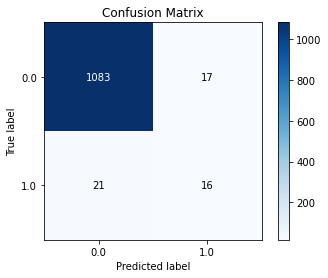

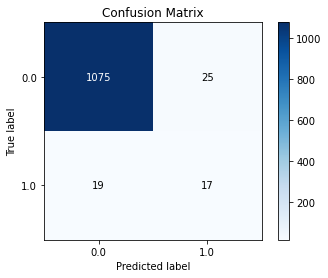

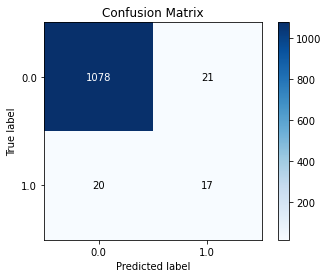

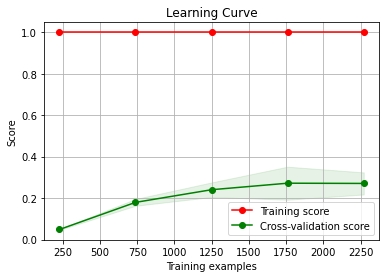

In [17]:
model = xgb.XGBClassifier(max_depth=5, n_estimators=100, random_state=0)
make_experiment(model, threshold=0.1, show_cm=True)

In [18]:
def my_hist1(df_all, feat_name, left_perc=1, right_perc=99):
    min_value = np.percentile( df_all[feat_name], 1)
    max_value = np.percentile( df_all[feat_name], 99)

    (
        df_all[ 
            (df_all['target'] == 1) &
            (df_all[feat_name] > min_value) &
            (df_all[feat_name] < max_value)
        ][feat_name]
    ).hist(bins=100)
    plt.title("{}\n, left_perc={}, right_perc={}".format(feat_name, left_perc, right_perc))
    plt.show()

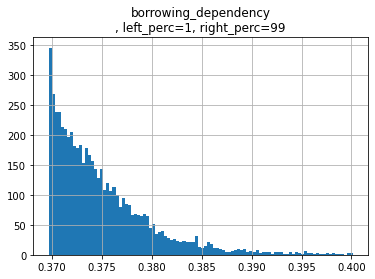

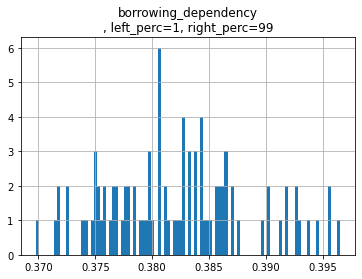

In [19]:
my_hist(df_all, "borrowing_dependency")
my_hist1(df_all, "borrowing_dependency")

In [20]:
print(df_all.shape)
feat = 'borrowing_dependency'
values = [0.37, 0.375, 0.38, 0.385, 0.39, 0.395, 0.4]
# w ostatecznym zgloszeniu linia poniżej była zakomentowana
#df_all["{}_[Group]".format( feat)] = np.digitize(df_all[feat], bins=values)
print(df_all.shape)

(6819, 1123)
(6819, 1123)


In [21]:
def reset_outlires(df, feat, prc1=1, prc2=99):
    cut_value_min = np.percentile(df[feat], prc1)
    cut_value_max = np.percentile(df[feat], prc2)
    return df[feat].map(lambda x: x if (x > cut_value_min) & (x < cut_value_max) else None)
          
bins = pd.cut(reset_outlires(df_all,"borrowing_dependency"), bins=15)

df_all['target'].groupby(bins).agg(['count','sum','mean'])

,count,sum,mean
borrowing_dependency,,,
"(0.37, 0.372]",820,2.0,0.002439
"(0.372, 0.374]",587,4.0,0.006814
"(0.374, 0.376]",461,9.0,0.019523
"(0.376, 0.378]",321,10.0,0.031153
"(0.378, 0.38]",236,9.0,0.038136
"(0.38, 0.382]",112,11.0,0.098214
"(0.382, 0.384]",79,13.0,0.164557
"(0.384, 0.386]",63,9.0,0.142857
"(0.386, 0.388]",27,10.0,0.370370


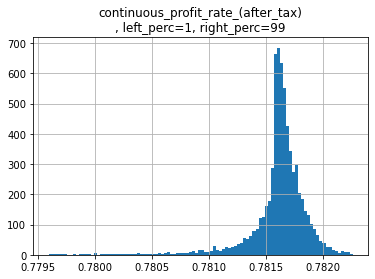

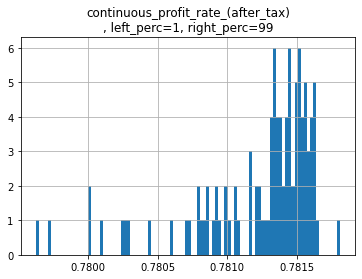

In [22]:
my_hist(df_all,  'continuous_profit_rate_(after_tax)');
my_hist1(df_all,  'continuous_profit_rate_(after_tax)');

In [23]:
print(df_all.shape)
feat = 'continuous_profit_rate_(after_tax)'
values = [0.7795, 0.78, 0.7805, 0.781, 0.7815, 0.782, 0.7825]
df_all["{}_[Group]".format( feat)] = np.digitize(df_all[feat], bins=values)
print(df_all.shape)

(6819, 1123)
(6819, 1124)


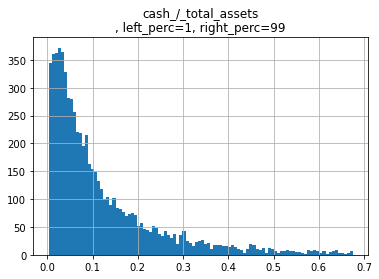

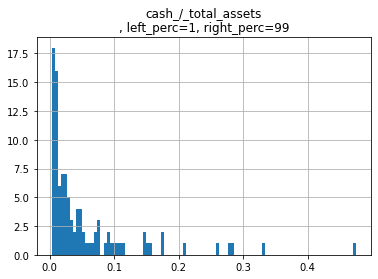

In [24]:
my_hist(df_all,  'cash_/_total_assets')
my_hist1(df_all,  'cash_/_total_assets')

In [25]:
print(df_all.shape)
feat = 'cash_/_total_assets'
values = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
df_all["{}_[Group]".format( feat)] = np.digitize(df_all[feat], bins=values)
print(df_all.shape)

(6819, 1124)
(6819, 1125)


Score:  0.44879120879120876 0.009248969401721709


Weight,Feature
0.0589,continuous_profit_rate_(after_tax)
0.0457,roa(a)_after_tax_and_before_interest%
0.0393,persistent_eps_in_the_last_four_seasons
0.0381,net_income_to_total_assets
0.0372,working_capital/equity
0.0325,quick_ratio
0.0288,interest_expense_ratio_[out2_5]
0.0276,total_debt/total_net_worth
0.0261,quick_asset/current_liabilities
0.0258,no-credit_interval_[out2_4]


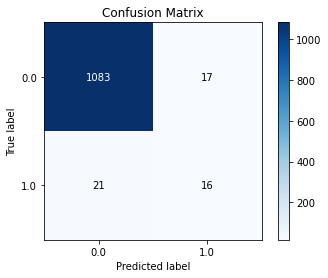

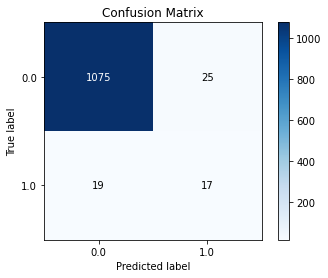

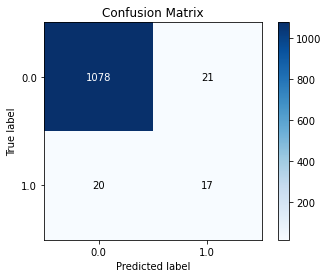

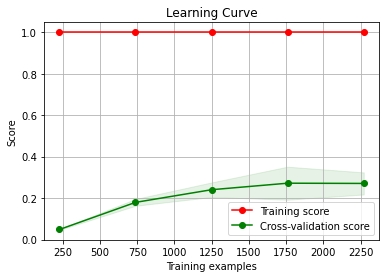

In [26]:
model = xgb.XGBClassifier(max_depth=5, n_estimators=100, random_state=0)
make_experiment(model, threshold=0.1, show_cm=True)

Score:  0.4354499039300932 0.06348822222472818


Weight,Feature
0.0735,roa(a)_after_tax_and_before_interest%
0.0503,cash_flow_ratio
0.0458,non-industry_revenue_and_expenditure/revenue
0.0431,debt_ratio%
0.0369,interest-bearing_debt_interest_rate
0.0321,cash_/_total_assets
0.0286,cash_/_current_liability
0.0285,borrowing_dependency
0.0259,total_debt/total_net_worth
0.0219,book_value_per_share_(c)


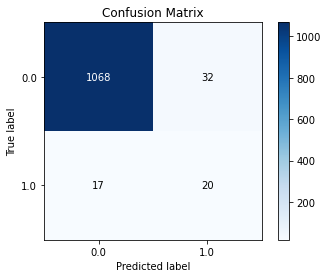

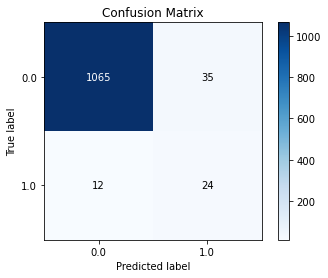

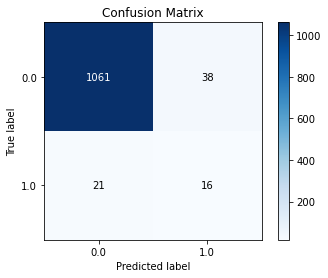

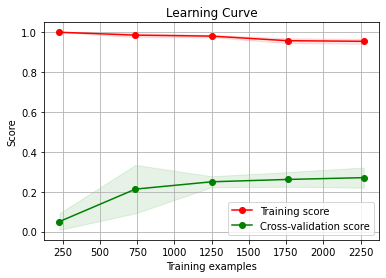

In [27]:
model = ctb.CatBoostClassifier(max_depth=5, n_estimators=100, verbose=0)
make_experiment(model, threshold=0.1, show_cm=True)

Score:  0.4476539834434572 0.04589798927869374


Weight,Feature
0.1284,continuous_profit_rate_(after_tax)
0.0855,working_capital/equity_[feat_range]
0.0504,cash_/_total_assets
0.0460,net_income_to_total_assets_[out2_L_4]
0.0444,borrowing_dependency
0.0401,retained_earnings/total_assets
0.0348,interest_coverage_ratio(_interest_expense_to_ebit_)
0.0307,net_income_to_total_assets
0.0262,interest-bearing_debt_interest_rate
0.0258,net_value/asset


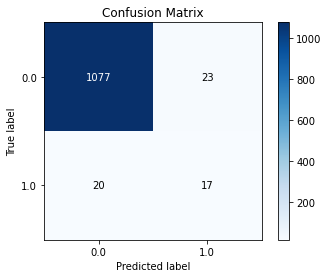

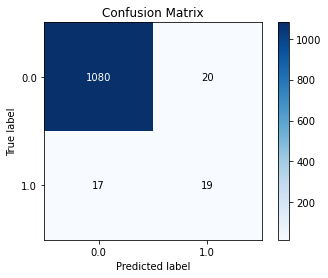

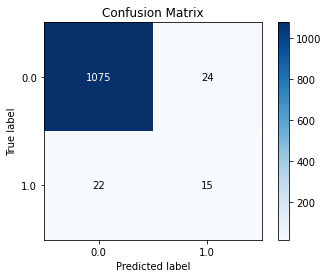

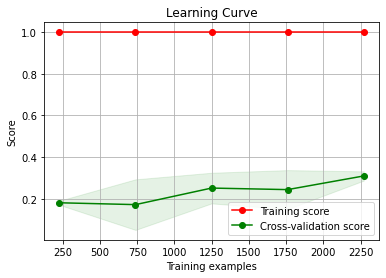

In [28]:
model = lgb.LGBMClassifier(max_depth=5, n_estimators=100)
make_experiment(model, threshold=0.1, show_cm=True)

In [29]:
model = xgb.XGBClassifier(max_depth=5, n_estimators=100, random_state=0)
save_result("xgb_threshold_0.1_end_1.csv", model)

model = ctb.CatBoostClassifier(max_depth=5, n_estimators=100, verbose=0)
save_result("ctb_threshold_0.1_end_1.csv", model)

model = lgb.LGBMClassifier(max_depth=5, n_estimators=100)
save_result("lgb_threshold_0.1_end_1.csv", model)

Saved:  ../output/xgb_threshold_0.1_end_1.csv
Saved:  ../output/ctb_threshold_0.1_end_1.csv
Saved:  ../output/lgb_threshold_0.1_end_1.csv


In [30]:
xgb_output = pd.read_csv("../output/xgb_threshold_0.1_end_1.csv")
lgb_output = pd.read_csv("../output/lgb_threshold_0.1_end_1.csv")
ctb_output = pd.read_csv("../output/ctb_threshold_0.1_end_1.csv")

(0.33*xgb_output["target"] + 0.34*lgb_output["target"] + 0.33*ctb_output["target"]).value_counts()

0.00    3202
1.00      95
0.33      65
0.67      28
0.66      10
0.34      10
Name: target, dtype: int64

In [31]:
output = pd.DataFrame()
output["id"] = xgb_output["id"]
output["target"] = ((0.33*xgb_output["target"] + 0.34*lgb_output["target"] + 0.33*ctb_output["target"]) > 0.2).astype(np.int)

output.to_csv("../output/0.33xgb_0.34lgb_0.33ctb_end_1.csv", index=False)